c:\Users\python\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.06568e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


验证集最佳集成方法: Weighted，RMSE: 0.015747


c:\Users\python\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.86704e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


测试集预测 RMSE: 0.013183
正对数收益率占比: 0.4412
负对数收益率占比: 0.5441
涨跌方向预测准确率: 0.7500
预测涨准确率（精确率）: 0.6944
预测跌准确率（精确率）: 0.8125
召回率: 0.7027


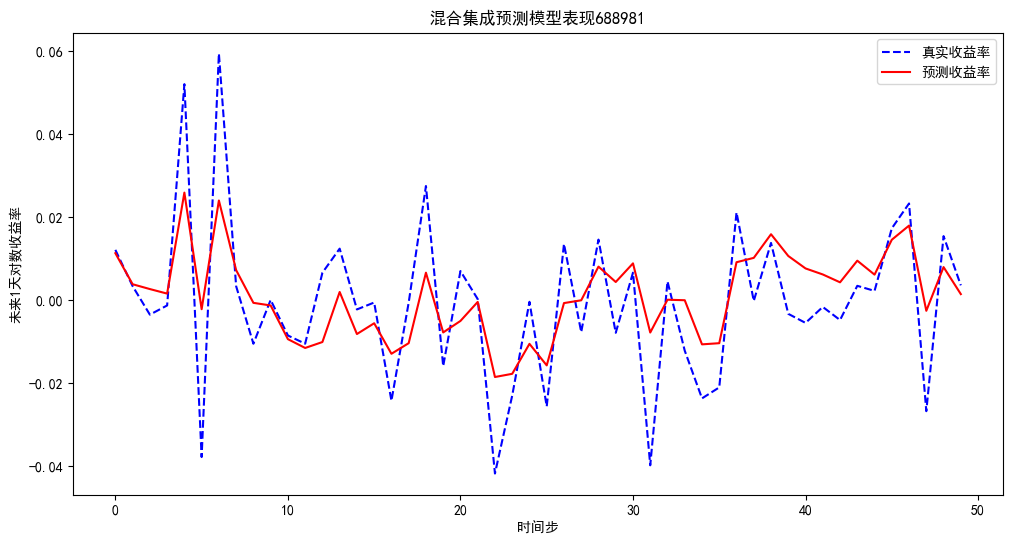

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取688981数据
data = pd.read_excel('688981_v3.xlsx')

# 2. 特征选择
high_freq_features = [
    "周波动率(%)_VolatilityWk", "换手率(%)_TurnRat_diff", 
    "周换手率(%)_TurnRatRecWk_diff", "成交量(股）_diff",
    "DIF_diff", "DEA_diff", "MACD", "K", "D", "J", "ATR_diff"
]
sentiment_features = ["umap_1", "umap_2"]
features = high_freq_features + sentiment_features
target = '对数收益率'

# 3. 填充缺失值
data[features] = data[features].fillna(0)

# 4. 划分训练/测试集
split_ratio = 0.8
split_index = int(len(data) * split_ratio)  

train_val = data.iloc[:split_index]    
test = data.iloc[split_index:]         

X_train_val = train_val[features]
y_train_val = train_val[target]
X_test = test[features]
y_test = test[target]

# 5. 训练集内部再划训练/验证集
split_inner_ratio = 0.8
split_inner_index = int(len(X_train_val) * split_inner_ratio)  

X_train_base = X_train_val.iloc[:split_inner_index]  
y_train_base = y_train_val.iloc[:split_inner_index]
X_val_base = X_train_val.iloc[split_inner_index:]    
y_val_base = y_train_val.iloc[split_inner_index:]

# 6. 定义单模型
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GBDT": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# 7. 单模型训练并验证预测
val_preds = {}
for name, model in models.items():
    model.fit(X_train_base, y_train_base)
    val_preds[name] = model.predict(X_val_base)

# 8. 集成方法
val_preds_df = pd.DataFrame(val_preds)

ensemble_methods = {
    "Mean": val_preds_df.mean(axis=1),
    "Median": val_preds_df.median(axis=1),
    "Max": val_preds_df.max(axis=1),
    "Min": val_preds_df.min(axis=1),
    "Weighted": val_preds_df.apply(lambda row: np.average(row, weights=[5,3,2,2,1]), axis=1)
}

# 9. 选择验证集最优集成方法
best_method = None
best_rmse = float('inf')
for method_name, pred in ensemble_methods.items():
    rmse = np.sqrt(mean_squared_error(y_val_base, pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_method = method_name

print(f"验证集最佳集成方法: {best_method}，RMSE: {best_rmse:.6f}")

# 10. 全训练集训练单模型
final_preds = {}
for name, model in models.items():
    model.fit(X_train_val, y_train_val)
    final_preds[name] = model.predict(X_test)

# 11. 测试集集成预测
final_preds_df = pd.DataFrame(final_preds)

if best_method == "Mean":
    y_pred = final_preds_df.mean(axis=1)
elif best_method == "Median":
    y_pred = final_preds_df.median(axis=1)
elif best_method == "Max":
    y_pred = final_preds_df.max(axis=1)
elif best_method == "Min":
    y_pred = final_preds_df.min(axis=1)
elif best_method == "Weighted":
    y_pred = final_preds_df.apply(lambda row: np.average(row, weights=[5,3,2,2,1]), axis=1)

# 12. 评估指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"测试集预测 RMSE: {rmse:.6f}")

y_test_class = np.sign(y_test.values)
y_pred_class = np.sign(y_pred.values if isinstance(y_pred, pd.Series) else y_pred)

pos_ratio = np.sum(y_test_class == 1) / len(y_test_class)
neg_ratio = np.sum(y_test_class == -1) / len(y_test_class)
print(f"正对数收益率占比: {pos_ratio:.4f}")
print(f"负对数收益率占比: {neg_ratio:.4f}")

accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"涨跌方向预测准确率: {accuracy:.4f}")

tp = np.sum((y_pred_class == 1) & (y_test_class == 1))
fp = np.sum((y_pred_class == 1) & (y_test_class != 1))
precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0

tn = np.sum((y_pred_class == -1) & (y_test_class == -1))
fn = np.sum((y_pred_class == -1) & (y_test_class != -1))
precision_neg = tn / (tn + fn) if (tn + fn) > 0 else 0

recall = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"预测涨准确率（精确率）: {precision_pos:.4f}")
print(f"预测跌准确率（精确率）: {precision_neg:.4f}")
print(f"召回率: {recall:.4f}")

# 13. 可视化结果
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50].values, label="真实收益率", color='blue', linestyle='dashed')
plt.plot(y_pred[:50].values, label="预测收益率", color='red')
plt.xlabel("时间步")
plt.ylabel("未来1天对数收益率")
plt.title("混合集成预测模型表现688981")
plt.legend()
plt.show()


验证集最佳集成方法: Median，RMSE: 0.011489
测试集预测 RMSE: 0.012137
正对数收益率占比: 0.5167
负对数收益率占比: 0.4833
涨跌方向预测准确率: 0.7000
预测涨准确率（精确率）: 0.8824
预测跌准确率（精确率）: 0.6279
召回率: 0.9310


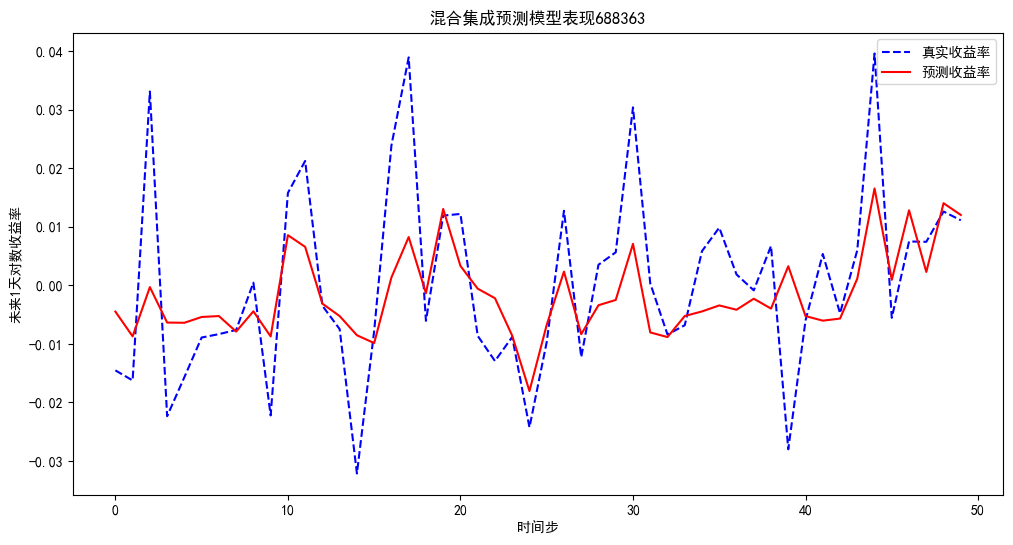

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取688363数据
data = pd.read_excel('688363_v3.xlsx')

# 2. 特征选择
high_freq_features = [
    "周波动率(%)_VolatilityWk_diff", "换手率(%)_TurnRat_diff", 
    "周换手率(%)_TurnRatRecWk_diff", "成交量_TrdVol_diff",
    "DIF_diff", "DEA_diff", "MACD", "K", "D", "J", "ATR_diff"
]
sentiment_features = ["umap_1", "umap_2"]
features = high_freq_features + sentiment_features
target = '对数收益率'

# 3. 填充缺失值
data[features] = data[features].fillna(0)

# 4. 划分训练/测试集
split_ratio = 0.8
split_index = int(len(data) * split_ratio)  

train_val = data.iloc[:split_index]    
test = data.iloc[split_index:]         

X_train_val = train_val[features]
y_train_val = train_val[target]
X_test = test[features]
y_test = test[target]

# 5. 训练集内部再划训练/验证集
split_inner_ratio = 0.8
split_inner_index = int(len(X_train_val) * split_inner_ratio)  

X_train_base = X_train_val.iloc[:split_inner_index]  
y_train_base = y_train_val.iloc[:split_inner_index]
X_val_base = X_train_val.iloc[split_inner_index:]    
y_val_base = y_train_val.iloc[split_inner_index:]

# 6. 定义单模型
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GBDT": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# 7. 单模型训练并验证预测
val_preds = {}
for name, model in models.items():
    model.fit(X_train_base, y_train_base)
    val_preds[name] = model.predict(X_val_base)

# 8. 集成方法
val_preds_df = pd.DataFrame(val_preds)

ensemble_methods = {
    "Mean": val_preds_df.mean(axis=1),
    "Median": val_preds_df.median(axis=1),
    "Max": val_preds_df.max(axis=1),
    "Min": val_preds_df.min(axis=1),
    "Weighted": val_preds_df.apply(lambda row: np.average(row, weights=[5,3,2,2,1]), axis=1)
}

# 9. 选择验证集最优集成方法
best_method = None
best_rmse = float('inf')
for method_name, pred in ensemble_methods.items():
    rmse = np.sqrt(mean_squared_error(y_val_base, pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_method = method_name

print(f"验证集最佳集成方法: {best_method}，RMSE: {best_rmse:.6f}")

# 10. 全训练集训练单模型
final_preds = {}
for name, model in models.items():
    model.fit(X_train_val, y_train_val)
    final_preds[name] = model.predict(X_test)

# 11. 测试集集成预测
final_preds_df = pd.DataFrame(final_preds)

if best_method == "Mean":
    y_pred = final_preds_df.mean(axis=1)
elif best_method == "Median":
    y_pred = final_preds_df.median(axis=1)
elif best_method == "Max":
    y_pred = final_preds_df.max(axis=1)
elif best_method == "Min":
    y_pred = final_preds_df.min(axis=1)
elif best_method == "Weighted":
    y_pred = final_preds_df.apply(lambda row: np.average(row, weights=[5,3,2,2,1]), axis=1)

# 12. 评估指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"测试集预测 RMSE: {rmse:.6f}")

y_test_class = np.sign(y_test.values)
y_pred_class = np.sign(y_pred.values if isinstance(y_pred, pd.Series) else y_pred)

pos_ratio = np.sum(y_test_class == 1) / len(y_test_class)
neg_ratio = np.sum(y_test_class == -1) / len(y_test_class)
print(f"正对数收益率占比: {pos_ratio:.4f}")
print(f"负对数收益率占比: {neg_ratio:.4f}")

accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"涨跌方向预测准确率: {accuracy:.4f}")

tp = np.sum((y_pred_class == 1) & (y_test_class == 1))
fp = np.sum((y_pred_class == 1) & (y_test_class != 1))
precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0

tn = np.sum((y_pred_class == -1) & (y_test_class == -1))
fn = np.sum((y_pred_class == -1) & (y_test_class != -1))
precision_neg = tn / (tn + fn) if (tn + fn) > 0 else 0

recall = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"预测涨准确率（精确率）: {precision_pos:.4f}")
print(f"预测跌准确率（精确率）: {precision_neg:.4f}")
print(f"召回率: {recall:.4f}")

# 13. 可视化结果
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50].values, label="真实收益率", color='blue', linestyle='dashed')
plt.plot(y_pred[:50].values, label="预测收益率", color='red')
plt.xlabel("时间步")
plt.ylabel("未来1天对数收益率")
plt.title("混合集成预测模型表现688363")
plt.legend()
plt.show()
